In [1]:
%matplotlib inline
from ggplot import *
import matplotlib as mpl
mpl.style.use('ggplot')
import pandas as pd
import numpy as np

## Introduction

Previously, we looked at fungal leucine tRNAs in GtRNAdb. Next, we're going to look at all eukaryotic leucine tRNAs in GtRNAdb. This will involve two extra steps. I'll need to build a phylogenetic tree, which will be used for autodetection of identity elements. This will replace the hardcoded yeast IDEs. 

We've learned that in fungi, the lower bound for _percentage of tRNAs missing an IDE_ is 20% in a single species, while every single species contained at least one tRNA with the proper IDEs. So for autodetection of IDEs, what can we set as a cutoff? What if all but one species has the IDEs? This could mean that the one species has a mutated synthetase. We need to set a boundary for the amount of evidence that will convince us that a conserved position is an identity element. I'd say that if 80% of species within a clade have the IDE in at least one tRNA, then it's convincing. 

## Workflow
One potential workflow is as follows:
1. Generate multi-tiered phylogenetic tree
2. Align and filter tRNAs from each clade
3. For each clade, find and score potential IDEs.
    - This includes base pairs and single bases.
    - Scoring will need to take into account a) number of species with at least one tRNA with the IDE, and b) percent of tRNAs with the IDE within each species. (a) is a scalar, while (b) is a vector. So we'll take the product of (a) and the mean of (b), for a score between 0 and 1. Let $s$ be the number of subclades in the clade, while $s_i$ is the subset of subclades containing at least one tRNA with an IDE $i$. $s$ can refer to species (e.g. _S. cerevisiae_ within fungi) or clades (e.g. fungi within eukaryotes). Let $t_s$ be the number of tRNAs within a subclade $s$, and $t_i$ be the number of tRNAs containing an IDE $i$. Then: 
$$\text{Score} = \frac{s_i}{s}\frac{\sum^s{t_{s,i}}}{s}$$
    - As a heuristic, we will not score any positions with $s_i < 0.8$.
4. Imagine a phylogenetic tree with root R branching into clades A, B, and C. If steps #2-#4 are performed for each of A, B, and C, we will now want to perform a R-wide analysis of the IDEs identified within subclades A, B, and C. Since this IDE analysis is entirely computational, some phylogenetic context is necessary. Then, we will want to perform a t-test for the scores of each IDE, between R and A (or B or C). The null hypothesis is that they are the same, e.g. conserved. 
    - Alternatively, we can assume that positions without evolutionary pressure have scores that follow a normal distribution, with a mean of $0.25 \cdot 0.25 = 0.0625$. But tRNAs are subject to a variety of compounding pressures, and have different evolutionary timelines, so actually, this is a silly assumption.
    - Either way, we will need to apply multiple testing corrections.
    
Unfortunately, this would fail in the case where the same position is mutated among different clades - for example, maybe fungi have A35 while mammals have G35. This requires a positional analysis. Instead of counting the number of tRNAs with an IDE, we can look at the R-wide information content. In theory, low information content means conservation. 

Given a method for finding positional IDE information, we should start with a list of positional IDEs, then try to resolve nucleotides. This also eliminates the need for subclade IDE autodetection, and instead we can just take the base or nucleotide at the proper position. So, we'll need to develop a cutoff for entropy. This would be used to determine the position of the base. Then we'd have to figure out a clade-wide nucleotide, which also needs a cutoff. I'm not too worried about this second cutoff, since we can just say something like 80%, and reanalyze subclades - the important thing is the entropy of the position. 

## Revised workflow
1. Generate multi-tiered phylogenetic tree
2. Align and filter tRNAs from each clade
3. **Find positions under entropy cutoff**
4. Resolve nucleotides corresponding to positions, if possible.
5. Resolve nucleotides for subclades.

In this notebook, I'll be performing this analysis for eukaryotic leucine tRNAs in order to find an appropriate entropy cutoff. Leucine is a good system since it is well studied, and has shared as well as differing IDEs between yeast and human. 

Later, we will want to look at identity element "suites" - what combinations of identity elements can be persistently found throughout a clade? This would be able to match the brain-specific arginine across species.

### Yeast/human leucine IDEs
Shared     |Yeast    |Human           |
:--------|---------|-----------------:
A73      |G35, G37 |C3:G70, A4:U69, G5:C68, C20a

We have a couple of options for determining entropy.

First, we can parse the alignment itself. For example, there are 925 As, 4 Us, and 21 Gs at position 73. There are also 2 Ns and 2 '-'s, which we don't count. Average entropy here is

$$-\sum^np_i\log_2{p_i}$$

In [2]:
from math import log2
-925/950*log2(925/950) - 4/950*log2(4/950) - 21/950*log2(21/950)

0.19225738255857028

Now if we look at position 69, this is the entropy you'd see from a typical position.

In [3]:
# 184 As, 36 Gs, 426 Us, 289 Cs
184+36+426+289

935

In [4]:
def entropy(n, total): return -n/total*log2(n/total)
entropy(184, 935) + entropy(36, 935) + entropy(426, 935) + entropy(289, 935)

1.6827342976356228

I thought about building a covariance model and parse the file to get emission log-odds bit scores for each possible nucleotide or base pair. This is different from what I calculated above: odds and probability are different. 

It's not clear how to consolidate log-odds into single positional scores. Range is loosely correlated with conservation for strong IDEs, but what if we had a subclade mutate the base at that position? Then for the position, we'd see a smaller range of bit scores, and it would be indistinguishable from variation. Overall, not being able to resolve multiple log odds scores into a scalar is probably because the range of possible odds is [0, $\infty$]. Unlike probabilities, which sum to 1, odds are unbounded. What we could do is recover the probabilities by taking the root inverse log. Then we can aggregate them using the above process.

But that would take too long, and we're trying to get a move on here. We'll stick with the former, finding positions with minimum entropy. 

## Finding an entropy cutoff

We'll come back to building a phylogenetic tree later. First, we'll get the entropy at each position and see if there's an easy cutoff. We use the R2 alignment used to build the leucine-specific CM, and also just the fungal tRNAs. Again, we use `--matchonly` to get the proper numbering, and ignore potential insertions/deletions.

In [5]:
%%bash
cp ../gtrnadb-fungi/fungi-Leu-tRNAs.sto .
cp ../../tRNAscan/models/1.6/fasta/euk-Leu-r2-031616.fa euk-Leu.fa
cmalign -g --notrunc --matchonly -o euk-Leu.sto /projects/lowelab/users/blin/tRNAscan/models/current/TRNAinf-euk-Leu.cm euk-Leu.fa > /dev/null

We need to dynamically determine what the secondary structure looks like. I use a combination of Sprinzl numbering and region numbering to track positions, since there are some weird tRNAs out there (variable loop, long D arm/D loop, G0, etc).

In [52]:
import re
from collections import Counter
from math import log2

class Position:
    def __init__(self, position, region, region_number, index=-1, paired=False, counts=None, num_obs=0, entropy=-1):
        self.position = position
        self.region = region
        self.region_number = region_number
        self.index = index
        self.paired = paired
        if counts is None:
            self.counts = Counter()
        else:
            self.counts = counts
        self.num_obs = num_obs
        self.entropy = entropy
    
    def __str__(self):
        return "Position {} ({} #{})".format(self.position, self.region, self.region_number)

class Region:
    def __init__(self, lower, upper, name):
        self.lower = lower
        self.upper = upper
        self.name = name
    
    def __str__(self):
        return "Region {} ({} ~ {})".format(self.name, self.lower, self.upper)

def annotate_positions(ss):
    loop_indices = [r.span() for r in re.finditer('\(+|<+|_+|>+|\)+', ss)]
    if len(loop_indices) == 14: regions = ['acceptor', 'dstem', 'dloop', 'dstem', 'acstem', 'acloop', 'acstem', 'vstem', 'vloop', 'vstem', 'tpcstem', 'tpcloop', 'tpcstem', 'acstem']
    elif len(loop_indices) == 11: regions = ['acceptor', 'dstem', 'dloop', 'dstem', 'acstem', 'acloop', 'acstem', 'tpcstem', 'tpcloop', 'tpcstem', 'acstem']
    regions = [Region(indices[0], indices[1], name) for indices, name in zip(loop_indices, regions[:])]
    region = regions[0]
    positions = []
    region_index = 0 # index to be used to iterate through regions list
    region_numbering = 0 # base numbering within a region
    for position in range(len(ss)):
        if region_index < len(regions):
            region = regions[region_index]
        else:
            positions.append(Position(position=str(position + 1), region='single', region_number=region_numbering + 1, index=len(positions), paired=False))
            continue
        if position < region.lower: # before the next region starts (or if it's the last region), annotate as single bases
            positions.append(Position(position=str(position + 1), region='single', region_number=region_numbering + 1, index=len(positions), paired=False))
            region_numbering += 1
        elif position == region.lower: # start of region: begin region numbering at 1
            if ss[position] == "(":
                paired_base = regions[-1].upper - 1
                positions.append(Position(position='{}:{}'.format(position + 1, paired_base + 1), region=region.name, region_number=1, index=len(positions), paired=True))
            elif ss[position] == "<":
                paired_base = regions[region_index + 2].upper - 1
                positions.append(Position(position='{}:{}'.format(position + 1, paired_base + 1), region=region.name, region_number=1, index=len(positions), paired=True))
            elif ss[position] in [')', '>']:
                pass
            else:
                positions.append(Position(position=str(position + 1), region=region.name, region_number=region_numbering + 1, index=len(positions), paired=False))
            region_numbering = 1
        elif position > region.lower and position <= region.upper - 1: # inside region: increment region numbering normally
            # find paired base, or skip if base is the opposite strand
            if ss[position] == "(":
                paired_base = regions[-1].upper - (position - regions[0].lower) - 1
                positions.append(Position(position='{}:{}'.format(position + 1, paired_base + 1), region=region.name, region_number=region_numbering + 1, index=len(positions), paired=True))
            elif ss[position] == "<":
                paired_base = regions[region_index + 2].upper - region_numbering - 1
                positions.append(Position(position='{}:{}'.format(position + 1, paired_base + 1), region=region.name, region_number=region_numbering + 1, index=len(positions), paired=True))
            elif ss[position] in [')', '>']:
                pass
            else:
                positions.append(Position(position=str(position + 1), region=region.name, region_number=region_numbering+1, index=len(positions), paired=False))
            region_numbering += 1
        if position == region.upper - 1: # end of region, reset region index and increment region number
            region_index += 1
            region_numbering = 0
        
    return positions

def count_positions(input_file, positions):
    # We've now annotated all of the positions. Time to count bases at each position.
    # Loop through all sequences in alignment
    alignment_fhandle = open(input_file) # refresh handle
    for line in alignment_fhandle:
        if line[0] in ["#", '\n', '/']: continue
        if len(line.split()) == 1: print(line)
        seqname, seq = line.strip().split()
        for position_index, position in enumerate(positions):
            if position.paired:
                index1, index2 = position.position.split(':')
                index1, index2 = int(index1), int(index2)
                base_pair = "{}:{}".format(seq[index1 - 1], seq[index2 - 1])
                positions[position_index].counts[base_pair] += 1
            else:
                index = int(position.position)
                base = seq[index - 1]
                positions[position_index].counts[base] += 1
    for index, position in enumerate(positions):
        positions[index].num_obs = sum(position.counts.values())
        positions[index].entropy = calculate_positional_entropy(positions[index])
    return positions

def calculate_positional_entropy(position):
    return sum(-count / position.num_obs * log2(count / position.num_obs) for count in position.counts.values())

alignment_fhandle = open('euk-Leu.sto')
positions = [] # list containing each position in the tRNA

# first, get secondary structure
for line in alignment_fhandle:
    if line[0:12] == '#=GC SS_cons':
        ss = line.strip().split()[-1]

# parse secondary structure into regions and positions
positions = annotate_positions(ss)

# get counts for each position by parsing Stockholm file
positions = count_positions('euk-Leu.sto', positions)

for position in positions:
    print(position, position.counts)


Position 1:83 (acceptor #1) Counter({'G:C': 1792, 'A:U': 270, 'G:U': 12, 'A:C': 7, 'C:C': 3, 'G:A': 3, 'U:A': 2, 'G:N': 1, 'U:U': 1, '-:-': 1, 'G:G': 1, '-:C': 1, 'U:C': 1, 'N:C': 1})
Position 2:82 (acceptor #2) Counter({'U:A': 790, 'G:C': 498, 'C:G': 414, 'G:U': 298, 'A:U': 71, 'U:G': 11, '-:-': 3, 'G:G': 2, 'C:A': 2, 'G:A': 2, 'A:A': 2, 'G:N': 1, 'C:U': 1, 'N:U': 1})
Position 3:81 (acceptor #3) Counter({'C:G': 1256, 'U:G': 424, 'U:A': 203, 'A:U': 123, 'G:C': 67, 'C:A': 5, 'A:G': 3, '-:-': 3, 'G:U': 3, 'G:G': 2, 'U:C': 2, 'C:C': 2, 'C:U': 1, 'U:U': 1, '-:A': 1})
Position 4:80 (acceptor #4) Counter({'A:U': 1632, 'G:C': 296, 'C:G': 76, 'U:A': 56, 'G:U': 8, 'U:U': 7, 'A:A': 7, 'A:C': 6, '-:-': 6, 'C:U': 2})
Position 5:79 (acceptor #5) Counter({'G:C': 1627, 'A:U': 252, 'C:G': 111, 'G:U': 47, 'U:A': 42, 'A:C': 5, '-:-': 4, 'G:A': 3, 'C:C': 2, 'U:G': 1, 'G:G': 1, 'G:-': 1})
Position 6:78 (acceptor #6) Counter({'G:C': 672, 'G:U': 651, 'C:G': 395, 'U:G': 213, 'A:U': 79, 'U:A': 71, '-:-': 4, '

Okay, all the data is processed and in place. Let's convert it into a data frame and plot in R.

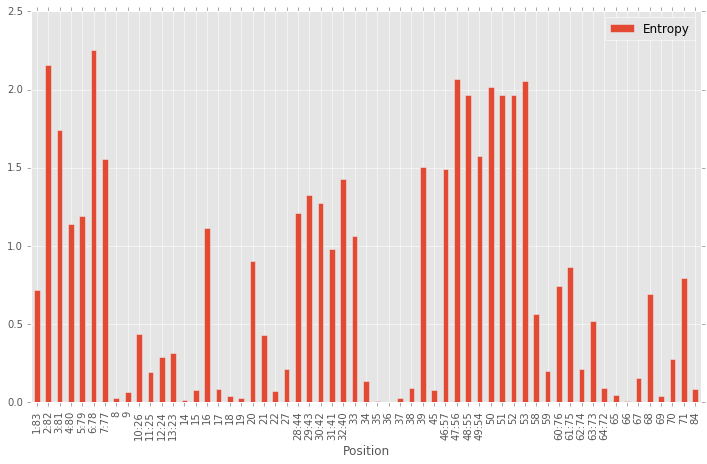

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
df = pd.concat(pd.DataFrame({'Position': [position.position], 
                              'Entropy': [position.entropy]}) for position in positions)
outfile = open('euk-Leu-entropy.tsv', 'w')
for position in positions:
    outfile.write('{}\t{}\n'.format(position.position, position.entropy))

df.plot(kind='bar', x='Position')
#ggplot(df, aes(x='Index', weight='Entropy')) + geom_bar() + theme(axis_text_x=element_text(angle=90, hjust=1)) + \
#    scale_x_discrete(breaks=list(df.Position),labels=list(df.Index))


In [23]:
%reload_ext rmagic
import rpy2.ipython

/projects/lowelab/users/blin/anaconda3/lib/python3.5/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


TypeError: type 'rpy2.rinterface.StrSexpVector' is not an acceptable base type

In [21]:
%R
df = read.table('euk-Leu-entropy.tsv')
df


ERROR: Line magic function `%R` not found.


NameError: name 'read' is not defined